# Backtesting with a Gap
### Single and Multiple Independent time-series: Direct & Recursive forecasting
Note: The arguments needed to achieve this configuration are `gap=n` and `refit=True` and `fixed_train_size=False`.   
Conda environment: `time-series`  
12 Jul 2024

In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Single time series

In [5]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.3798,0.9588,1.1660
1,1992-05-01,0.3618,0.9520,1.1179
2,1992-06-01,0.4105,0.9530,1.0679
3,1992-07-01,0.4834,0.9581,1.0974
4,1992-08-01,0.4755,0.9564,1.1222
...,...,...,...,...
190,2008-02-01,0.7618,1.5158,1.7864
191,2008-03-01,0.6494,1.5063,1.6943
192,2008-04-01,0.8279,1.5053,1.6271
193,2008-05-01,0.8163,1.4915,1.5551


In [6]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.3798,0.9588,1.1660
1992-05-01,0.3618,0.9520,1.1179
1992-06-01,0.4105,0.9530,1.0679
1992-07-01,0.4834,0.9581,1.0974
1992-08-01,0.4755,0.9564,1.1222


In [7]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


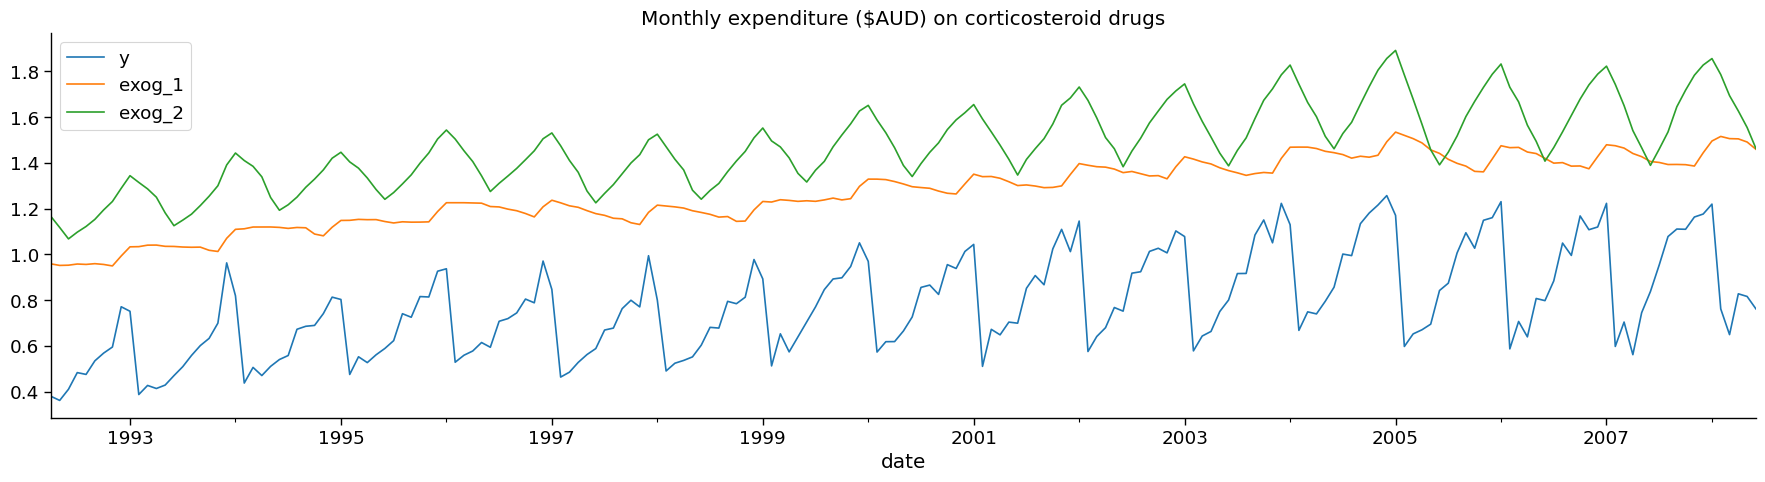

In [8]:
# Plot data
ax = data.plot()
ax.set_title("Monthly expenditure ($AUD) on corticosteroid drugs")
plt.show()

### 1.2) Direct Forecasting

In [16]:
# Number of steps to forecast. 
# This needs to include the size of the gap. If we want a gap of 3, and forecast 7 steps after the gap we need to set steps=10.
steps = 10

forecaster = ForecasterAutoregDirect(
    regressor=Ridge(alpha=1),
    lags=6,
    steps=steps,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# Initial training set size
initial_train_size = 100

# Gap between train and test
gap = 3

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    allow_incomplete_fold=True,
    fixed_train_size=False,
    gap=gap,
    steps=steps - gap,  # This needs to be the size of the test set. 
    metric="mean_squared_error",
    refit=True,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric: .4f}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 100
Number of observations used for backtesting: 95
    Number of folds: 14
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 3
    Last fold only includes 1 observations.

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2000-07-01 00:00:00  (n=100)
    Validation: 2000-11-01 00:00:00 -- 2001-05-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-02-01 00:00:00  (n=107)
    Validation: 2001-06-01 00:00:00 -- 2001-12-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2001-09-01 00:00:00  (n=114)
    Validation: 2002-01-01 00:00:00 -- 2002-07-01 00:00:00  (n=7)
Fold: 3
    Training:   1992-04-01 00:00:00 -- 2002-04-01 00:00:00  (n=121)
    Validation: 2002-08-01 00:00:00 -- 2003-02-01 00:00:00  (n=7)
Fold: 4
    Training:   1992-04-01 00:00:00 -- 2002-11-01 00:00:00  (n=128)


/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/skforecast/model_selection/model_selection.py:554: LongTrainingWarning: The forecaster will be fit 140 times (14 folds * 10 regressors). This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

Backtest metric (MSE):  0.0121


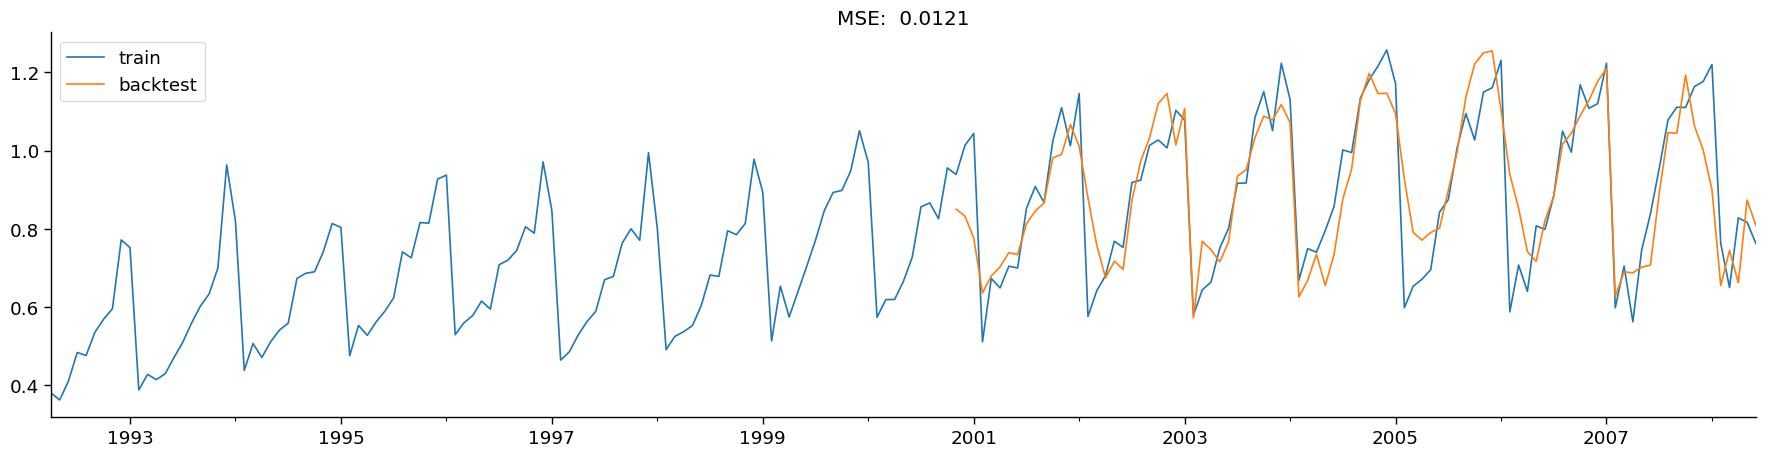

In [17]:
error_mse = mean_squared_error(
    y_true=data["y"].loc[predictions.index], y_pred=predictions
)

fig, ax = plt.subplots()
data["y"].plot(ax=ax, label="train")
predictions["pred"].plot(ax=ax, label="backtest")
ax.legend()

plt.title(f"MSE: {error_mse: .4f}")
plt.xlabel("")
plt.show()

## 2) Multiple Independent time-series

In [27]:
# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [28]:
# Data preprocessing

selected_store = 2
selected_items = data.item.unique()  # All items
# selected_items = [1, 2, 3, 4, 5] # Selection of items to reduce computation time

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")

# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data.head(4)

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000


In [29]:
# Check if any missing values introduced
data.isnull().sum().any()

False

/var/folders/fd/vdpcq4tn1v3fbxg5302hgb980000gq/T/ipykernel_88189/762125342.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


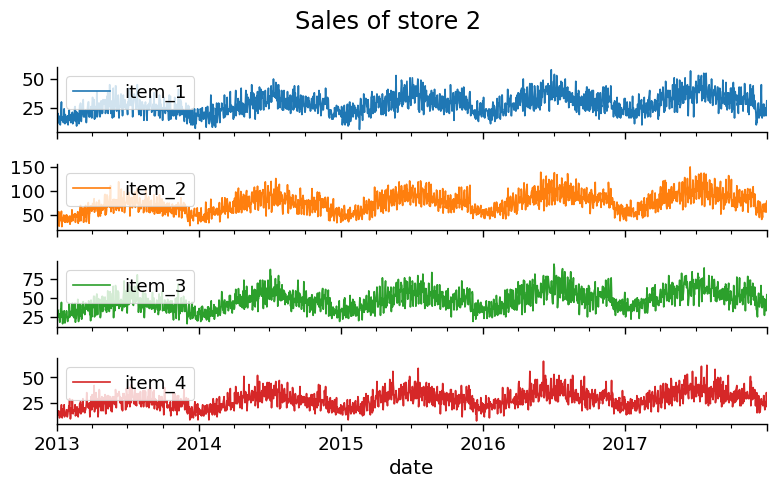

In [30]:
# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)
fig.tight_layout();

In [31]:
data["day_of_week"] = data.index.weekday

### 2.1) Multiple Independent time-series: Recursive forecasting

In [32]:
forecaster = ForecasterAutoregMultiSeries(
    regressor=Ridge(alpha=1),
    lags=31,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# Define column names of target variables
target_cols = data.filter(like="item_").columns

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Initial training set size
initial_train_size = 1700

# Gap between training and test set
gap = 3

# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    initial_train_size=initial_train_size,
    gap=gap,
    steps=steps,
    metric=["mean_absolute_error", "mean_squared_error"],
    fixed_train_size=False,
    refit=True,
    verbose=True,
    show_progress=True,
    allow_incomplete_fold=True,
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1700
Number of observations used for backtesting: 126
    Number of folds: 18
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 3
    Last fold only includes 4 observations.

Fold: 0
    Training:   2013-01-01 00:00:00 -- 2017-08-27 00:00:00  (n=1700)
    Validation: 2017-08-31 00:00:00 -- 2017-09-06 00:00:00  (n=7)
Fold: 1
    Training:   2013-01-01 00:00:00 -- 2017-09-03 00:00:00  (n=1707)
    Validation: 2017-09-07 00:00:00 -- 2017-09-13 00:00:00  (n=7)
Fold: 2
    Training:   2013-01-01 00:00:00 -- 2017-09-10 00:00:00  (n=1714)
    Validation: 2017-09-14 00:00:00 -- 2017-09-20 00:00:00  (n=7)
Fold: 3
    Training:   2013-01-01 00:00:00 -- 2017-09-17 00:00:00  (n=1721)
    Validation: 2017-09-21 00:00:00 -- 2017-09-27 00:00:00  (n=7)
Fold: 4
    Training:   2013-01-01 00:00:00 -- 2017-09-24 00:00:00  (n

  0%|          | 0/18 [00:00<?, ?it/s]

In [33]:
metric.head()

,levels,mean_absolute_error,mean_squared_error
0,item_1,5.2314,44.9183
1,item_2,9.1660,143.5266
2,item_3,6.9738,80.5230
3,item_4,4.8198,40.6257
4,item_5,4.1137,28.5448


In [34]:
predictions.head()

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2017-08-31,35.1281,91.3342,56.5575,37.0112,25.7476,94.7201,98.1455,126.7229,85.4633,125.8866,118.3698,111.8266,136.6365,96.6024,145.0206,41.2259,60.4719,141.9486,61.6434,79.1319,64.5475,127.1563,50.9522,109.2198,131.4388,76.0908,34.6409,144.1980,111.9236,68.9833,97.1197,75.7000,112.6407,42.1952,112.0111,124.0217,48.3553,126.1016,69.5010,46.3867,36.7356,63.0580,81.9763,49.0254,139.4590,91.2709,36.5716,81.9634,47.1118,105.4774
2017-09-01,37.5912,96.1261,62.7791,39.7648,28.1034,98.0303,99.0532,132.9161,89.2435,132.1086,123.7931,116.7637,144.6391,99.5863,152.3924,43.9774,60.0380,146.9490,64.4523,83.3032,69.9261,135.1367,54.9807,115.5923,137.4753,83.2231,36.4887,153.9157,118.4933,73.8174,100.9833,79.1665,120.6830,44.9498,116.5765,128.8277,49.1730,134.7009,73.6341,50.7726,37.4235,65.9697,88.5902,50.9716,142.9843,95.6081,37.4930,88.1894,48.2598,111.4651
2017-09-02,39.2031,100.0190,62.5873,41.9279,29.3146,104.5598,107.2244,138.0041,93.0383,133.8444,128.2570,122.7972,151.3150,107.0576,162.6398,46.3737,63.9882,157.3914,69.1385,84.9225,72.6674,141.4910,57.4507,121.7193,145.6449,87.6171,37.0569,160.3650,126.1444,74.1678,106.4325,82.4187,123.9304,46.6515,121.6413,136.4920,53.8316,139.8994,76.2595,50.4056,39.2802,68.6402,92.6745,53.8199,149.0413,102.6209,40.8993,92.0280,53.0386,114.7457
2017-09-03,40.8753,106.0545,66.7155,45.0988,31.3445,107.9680,111.5331,144.6332,99.4264,143.4167,135.5566,124.4905,158.4485,110.8342,165.3806,47.0224,67.8138,162.1999,71.4029,89.5295,75.0887,148.2854,59.3263,126.9412,151.6287,91.2292,42.8348,168.4268,128.3059,79.6647,111.7033,86.4309,129.6817,50.1724,127.6062,143.3450,55.4220,146.6803,81.6007,55.0959,42.1348,71.5002,96.0612,56.8949,157.7179,105.6342,42.0865,94.3712,54.4291,122.5765
2017-09-04,29.8839,75.3941,49.1276,31.1188,19.9519,78.3663,81.2393,106.4643,71.6512,101.5368,98.4357,92.3086,112.9631,80.7546,122.5900,34.5991,48.5626,117.1474,50.8938,65.6408,55.1804,109.9029,43.5700,92.3452,108.4839,65.3127,27.6438,123.8521,95.7368,56.5274,80.1321,61.9089,94.7971,35.4085,93.9179,102.7170,39.7431,107.0140,57.4598,38.4163,28.8282,52.1574,70.6730,41.0508,115.3747,76.1293,30.9747,70.3218,38.4225,86.5184


In [39]:
mae_error = mean_absolute_error(
    y_true=data[target_cols].loc[predictions.index],
    y_pred=predictions,
)

print(f"MAE: {mae_error: .4f}")

MAE:  8.6257


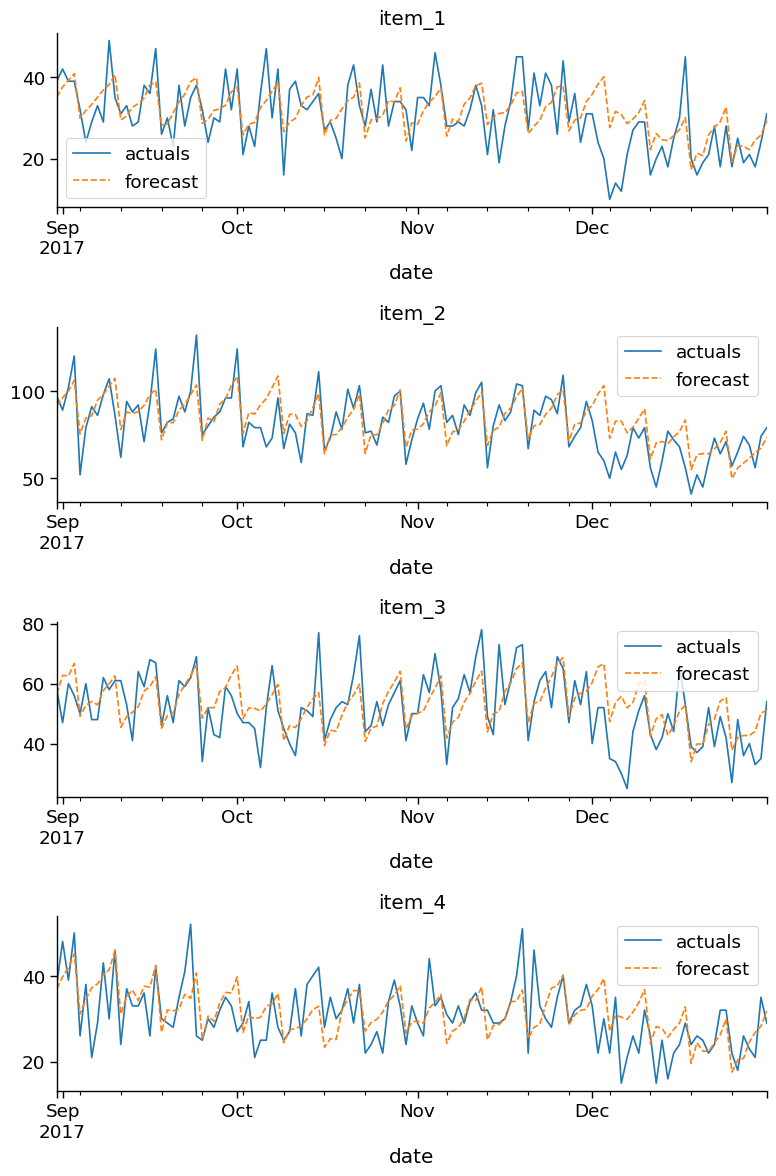

In [35]:
# Plot predictions
num_timeseries = 4
fig, axs = plt.subplots(nrows=num_timeseries, figsize=(8, 3*num_timeseries))
for i in range(4):
    timeseries = data.columns[i]
    data.iloc[-len(predictions):, i].plot(
        legend=True,
        label="actuals",
        ax=axs[i],
    )
    predictions.iloc[:, i].plot(
        legend=True,
        label="forecast",
        linestyle="--",
        ax=axs[i],
    )
    axs[i].set_title(f"{timeseries}")
    fig.tight_layout();